# Tutorial for BayBooNE: Baysian Booster Neutrino Experiment python package


This package is designed to use Bayesian parameter estimation to find sterile neutrino oscillation parameters ($\Delta m_{14}^2, sin^2 2\theta_{14}$) from a data sample containing initial muon neutrino flux and number of electron neutrinos detected at a particular neutrino energy.

To do so, we first simulate a short-baseline neutrino oscillation dataset for a particular ($\Delta m^2, sin^2 2\theta$) pair, and then use a pymc3-based algorithm to infer the parameters from our simulated data.

In [1]:
# Package dependencies and data visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns
import arviz as az

# Inference package componenets
from bayboone.data_io import Data, OscProbability
from bayboone.inference import module as ifunc

## Create a sample dataset by simulating data based on short baseline experiments.

Our simulation draws from known values of neutrino energy $E$ and distance from detector $L$ to calculate $\nu_\mu$ to $\nu_e$ oscillation probability, and then adjusts for overall flux (in progress). 

Importantly, we use $$ P_{\nu_{\mu} -> \nu_{e-}} = sin^2(2\theta_{14})sin^2(1.27\frac{\Delta m^2 L}{E})$$ to get the oscillation probability, and then simulate a certain number of muon neutrinos which randomly oscillate to electron neutrinos based on the $P_{\nu_{\mu} -> \nu_{e-}}$ for the neutrino.

To simulate a neutrino experiment, you can use the simulate_detector function, where you can specify the oscillation parameters, the number of muon neutrinos per energy bin, the energy bin edges, the baseline (muon neutrino travel distance $L$), and the uncertainty on $L$.

In [2]:
ss2t = 0.7
dms = 10e-3
N_numu = np.array([100, 1000, 10000, 100000])
E = np.array([.1, 0.5, 1.0, 2.0, 3.0]) # GeV
L = 4.0 # km
sigma_L = 0.1
sigma_E = 0.1
generic_data = Data.simulate_detector(ss2t, dms, N_numu, E, L, sigma_L)

Data:  600000 82610


Our simulation gives us the number muon neutrinos shot at the detector for a given energy bin (N_numu) and the number of muon neutrinos that oscillated to electron neutrinos given that energy bin (N_Nue).

In [3]:
print(generic_data)

Data:  100000 195


To simulate data from the microboone experiment, you can use the default arguments for everything but the oscillation parameters like so:

In [4]:
ss2t = 0.5
dms = 0.8
uboone_data = Data.simulate_detector(ss2t, dms)
print(uboone_data)

N_numu = 600000, N_nue = 82610


Below, we plot the theoretical oscillation probability from which we simulated our data, and display a point in that curve our simulated data represents.

Text(0.5, 0, 'L')

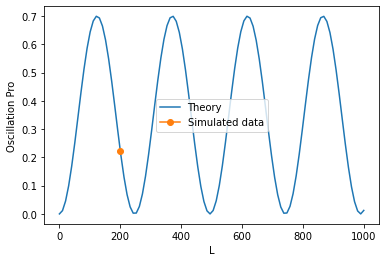

In [5]:
L_array = np.linspace(0.1,1000, 100)
plt.plot(L_array, OscProbability(ss2t, dms, L_array, 3.5), label='Theory')
plt.plot(200, OscProbability(ss2t, dms, 200, 3.5), marker='o', label='Simulated data')
plt.legend()
plt.ylabel('Oscillation Pro')
plt.xlabel('L')

You can also simulate data from a single energy bin, by inputing an integer and float for N_numu and E:

In [ ]:
single_E_data = Data.simulate_detector(ss2t, dms, 100, 1.0)
print(single_E_data)

Lastly, you can input the number of electron neutrinos seen yourself to further test the parameter space: 

In [ ]:
N_numu = 1000
N_nue = 10
E = 1.0
hardcoded_data = Data(N_numu, N_nue, E)
print(hardcoded_data)


## Infer $\Delta m^2$ and $sin^2 2\theta$ from our simulated data.

We make use of three functions from our inference_functions pacakge (imported here as ifunc):

-  oscillation_model: sets up our model in pymc3
-  fit_model: fits data to the statistical model
-  print_fit_vals: prints the quartile intervals for the fits on our mixing parameters

Our statistical model for predicting how many electron neutrinos appear is given by:

\begin{align}
    sin^2(2\theta) &\sim \text{Truncated Normal}(\mu = \text{estimated } sin^2(2\theta), \sigma = 0.1) \\
    \Delta m^2 &\sim \text{Truncated Normal}(\mu = \text{estimated }\Delta m^2, \sigma = 0.1) \\
    L &\sim \text{Truncated Normal}(\mu = 0.5, \sigma = 0.05) \\
    E &\sim \text{Truncated Normal}(\mu = 1.0, \sigma = 0.05) \\
    \text{rate} &= \#\nu_{mu}sin^2(2\theta_{14})sin^2(1.27\frac{\Delta m^2 L}{E}) \\
    \#\nu_{e-} &\sim \text{Poisson}(\mu = \text{rate})
\end{align}
We're treating the distributions of L and E as priors rather than known parameters due to their associated uncertainties - based on the way neutrinos beams produce neutrinos, both distance travelled and energy is variable.

In this version of the model, $sin^2(2\theta)$ and $\Delta m^2$ are drawn from truncated Gaussians around estimated values of each parameter. At the moment, the default values have been chosen to produce large oscillations for demonstrative purposes. The intention is that these parameters be chosen after review of estimates by previous experiments on sterile neutrino oscillation. This allows each region of ($sin^2(2\theta)$, $\Delta m^2$) parameter space to be treated as an independent model, a method well-suited to addressing the "islands" of probable values that have been produced by previous frequentist analyses of this problem.

Pymc3 transforms some of these distributions for ease of computation, so the pymc3 model used is printed by the next cell.

In [6]:
osc_model = ifunc.oscillation_model(600000, 10)

TypeError: Outputs must be theano Variable or Out instances. Received TensorConstant{0.5} of type <class 'theano.tensor.var.TensorConstant'>

Now we're going to use our package to do basic MCMC inference on the neutrino mixing parameters. We'll treat $L$ and $E$ as nuisance parameters for this project. This example data corresponds to $\Delta m^2 = 0.8 eV^2$, $sin^2(2\theta) = 0.5$.

In [7]:
data = Data(60000, 2) 
trace = ifunc.fit_model(data.N_numu, data.N_nue)

TypeError: 'NoneType' object is not iterable

Now, let's take our output and look at the marginalized distributions of $sin^2(2\theta)$ and $\Delta m^2$

In [ ]:
az.plot_trace(trace)

In [ ]:
df_trace = pm.trace_to_dataframe(trace)

In [ ]:
joint_kde = sns.jointplot(x='delta_m^2', y='sin^2_2theta', data=df_trace, kind='scatter', s=0.2)

As a final step, we'll take a look at the quartile intervals of the posterior distributions for our mixing parameters.

In [ ]:
ifunc.print_fit_vals(trace)

The quartile ranges for the estimates on $\Delta m^2$ and $sin^2(2\theta)$ include the values we used to generate data, which is a positive indication. However, keep in mind that this fake-data sample was generated with the same mixing parameters as we've chosen as the means for our priors on $\Delta m^2$ and $sin^2(2\theta)$, so this is expected. Using real data is expected to produce messier results.